In [15]:
import tomopy as tp
import dxchange as dx
import numpy as np
import radonusfft
import ctypes
import matplotlib.pyplot as plt

In [16]:
# load data using dxchange
#fname = '/data/tomography/shale/originals/00001/tomo_00001.h5'
fname = '/data/tomography/glass/originals/00058/tomo_00058.h5'

In [17]:
# read two sinograms
start = 1024
end = 1025
proj0, flat0, dark0, theta0 = dx.read_aps_32id(fname, sino=(start, end))
proj1, flat1, dark1, theta1 = dx.read_aps_32id(fname, sino=(start+1, end+1))

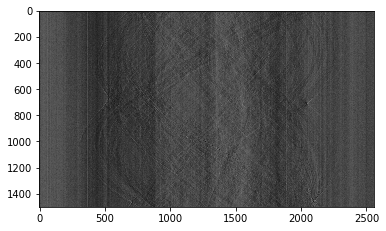

In [18]:
plt.imshow(proj0[:, 0, :], cmap='Greys_r')
plt.show()

In [19]:
proj0 = tp.normalize(proj0, flat0, dark0)
proj1 = tp.normalize(proj1, flat1, dark1)

In [20]:
#rot_center = 1024. # shale
rot_center = 1427. # glass

In [21]:
proj0 = tp.minus_log(proj0)
proj1 = tp.minus_log(proj1)

In [23]:
#N = 2048 # shale, object size in 1 dimension
#Ntheta = 1501 # shale, number of angles
N = 2560 # glass, object size in 1 dimension
Ntheta = 1500 # glass, number of angles
Nz = 1 # number of slices 
center = rot_center # rotation center
theta = np.float32(theta0) #np.float32(np.arange(0, Ntheta)*np.pi/Ntheta) # angles

In [24]:
# numpy array are sent to C code by pointers
def getp(a):
    return a.__array_interface__['data'][0]

In [25]:
# create class for the transform with allocating memory on GPU
cl = radonusfft.radonusfft(getp(theta), center, Ntheta, Nz, N)

In [26]:
g = proj0[:,0:1,:] + 1j*proj1[:,0:1,:] # put 2 projections to imaginary and real parts
type(g[0][0][0])

numpy.complex64

In [27]:
# inversion
ff = np.zeros([Nz, N, N], dtype="complex64")# memory for result
cl.adj(getp(ff), getp(g))

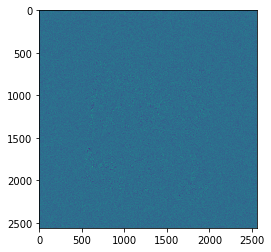

In [28]:
rec0= np.float32(ff[0, :, :].real)
plt.imshow(rec0[:, :])

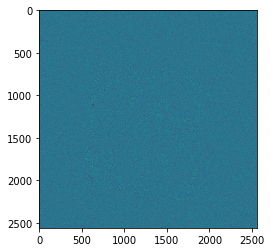

In [29]:
rec1 = np.float32(ff[0, :, :].imag)
plt.imshow(rec1[:, :])

In [31]:
print("{}; {}; {}; {}".format(np.min(rec0[:, :]), np.max(rec0[:, :]), np.min(rec1[:, :]), np.max(rec1[:, :])))

-0.013412951491773129; 0.023767368867993355; -0.013379586860537529; 0.021257514134049416


In [32]:
dx.write_tiff(rec0)

In [33]:
dx.write_tiff(rec1)

In [30]:
!pwd

/local/tbicer/projects/radonusfft
